<a href="https://colab.research.google.com/github/tiadwi/GoogleBangkit-MaskClassification/blob/master/FaceMask_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

### **Download Datasets from Kaggle**

In [0]:
#! pip install -q kaggle
#from google.colab import files
#files.upload()

In [0]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [0]:
#! kaggle datasets download -d 'ahmetfurkandemr/mask-datasets-v1'
#! mkdir GoogleBangkit
#! unzip mask-datasets-v1.zip -d GoogleBangkit

### **Define the Data Directory**

In [0]:
base_dir = '/content/GoogleBangkit/Mask_Datasets'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training Mask/No Mask pictures
train_Mask_dir = os.path.join(train_dir, 'Mask')
train_No_Mask_dir = os.path.join(train_dir, 'No_mask')

# Directory with our validation cat/dog pictures
validation_Mask_dir = os.path.join(validation_dir, 'Mask')
validation_No_Mask_dir = os.path.join(validation_dir, 'No_mask')

In [6]:
print('total training Mask images :', len(os.listdir(      train_Mask_dir ) ))
print('total training No Mask images :', len(os.listdir(      train_No_Mask_dir ) ))

print('total validation Mask images :', len(os.listdir( validation_Mask_dir ) ))
print('total validation No Mask images :', len(os.listdir( validation_No_Mask_dir ) ))

total training Mask images : 350
total training No Mask images : 400
total validation Mask images : 150
total validation No Mask images : 200


### **Image Visualization**

In [7]:
# Now, let's see what the filenames look like in the Mask and no mask train directories 
# (file naming conventions are the same in the validation directory)

train_Mask_fnames = os.listdir( train_Mask_dir )
train_No_Mask_fnames = os.listdir( train_No_Mask_dir )

print(train_Mask_fnames[:10])
print(train_No_Mask_fnames[:10])

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

['200.PNG', '158.PNG', '285.PNG', '146.PNG', '244.PNG', '337.PNG', '102.PNG', '113.PNG', '345.PNG', '179.PNG']
['15474.png', '15670.png', '15634.png', '15485.png', '15617.png', '15698.png', '15432.png', '15628.png', '15543.png', 'Juan_Carlos_Ferrero_0019.jpg']


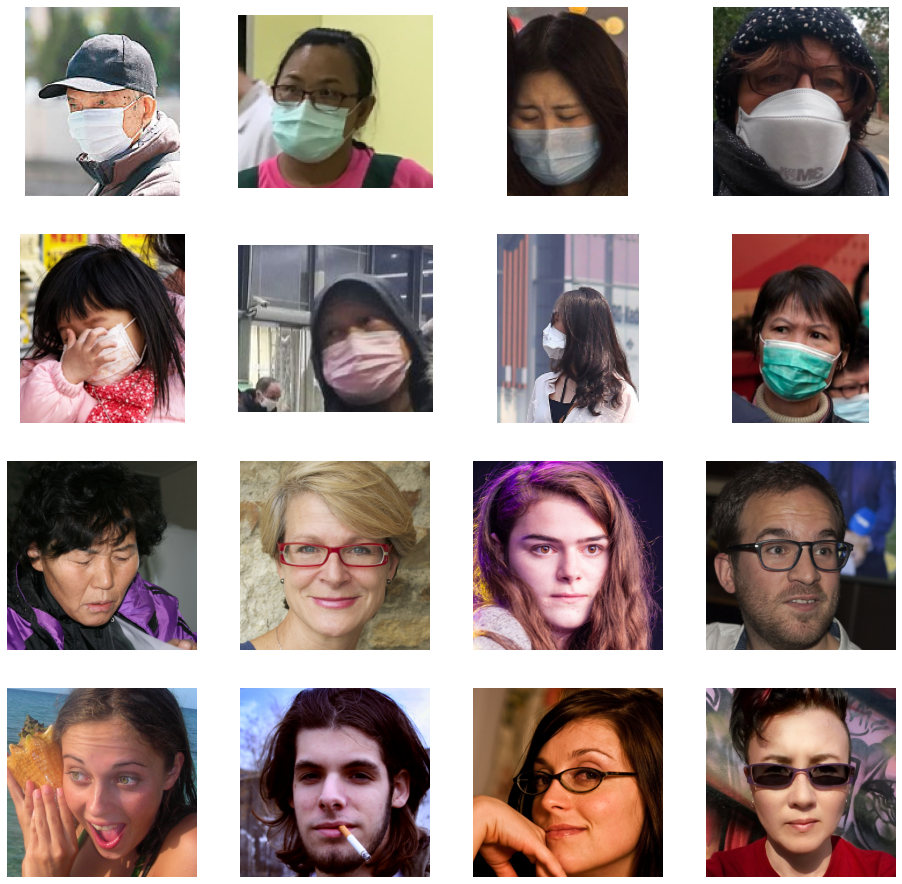

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Mask_pix = [os.path.join(train_Mask_dir, fname) 
                for fname in train_Mask_fnames[ pic_index-8:pic_index] 
               ]

next_No_Mask_pix = [os.path.join(train_No_Mask_dir, fname) 
                for fname in train_No_Mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Mask_pix+next_No_Mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### **3 LAYERS CNN MODEL**

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Mask') and 1 for the other ('No_Mask')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### **Image Augmentation using ImageDataGenerator**

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# The ImageGenerator rescaling, rotate and do other operations.
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      callbacks=[callbacks],
      verbose=2)

Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Epoch 1/50
38/38 - 29s - loss: 0.6186 - accuracy: 0.6467 - val_loss: 0.4036 - val_accuracy: 0.8629
Epoch 2/50
38/38 - 29s - loss: 0.4675 - accuracy: 0.7907 - val_loss: 0.2934 - val_accuracy: 0.9114
Epoch 3/50
38/38 - 29s - loss: 0.4065 - accuracy: 0.8360 - val_loss: 0.3204 - val_accuracy: 0.8686
Epoch 4/50
38/38 - 30s - loss: 0.3770 - accuracy: 0.8360 - val_loss: 0.1982 - val_accuracy: 0.9371
Epoch 5/50
38/38 - 30s - loss: 0.3489 - accuracy: 0.8640 - val_loss: 0.1825 - val_accuracy: 0.9514
Epoch 6/50
38/38 - 29s - loss: 0.3260 - accuracy: 0.8587 - val_loss: 0.1812 - val_accuracy: 0.9514
Epoch 7/50
38/38 - 30s - loss: 0.3448 - accuracy: 0.8453 - val_loss: 0.1892 - val_accuracy: 0.9543
Epoch 8/50
38/38 - 30s - loss: 0.3252 - accuracy: 0.8573 - val_loss: 0.1679 - val_accuracy: 0.9343
Epoch 9/50
38/38 - 30s - loss: 0.3050 - accuracy: 0.8733 - val_loss: 0.1524 - val_accuracy: 0.9571
Epoch 10/50
38/38 - 29s - l

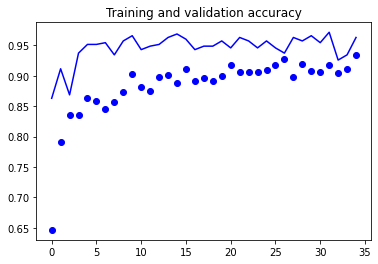

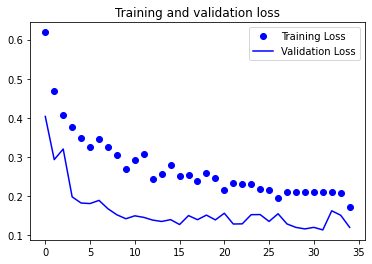

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()